# Imports

In [72]:
import os
import pandas as pd
import re
import json
from collections import defaultdict
from tqdm import tqdm
from collections import Counter

# Read data

In [2]:
# Paths
csv_path = '/home/coder/project/covidxct/metadata.csv'
image_folder = '/home/coder/project/covidxct/3A_images'

# Load your metadata
df = pd.read_csv(csv_path)
df

,patient id,source,country,sex,age,finding,verified finding,slice selection,view,modality
0,CP_0,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
1,CP_10,CNCB,China,NaN,NaN,Pneumonia,Yes,Automatic,Axial,CT
2,CP_1068,CNCB,China,NaN,NaN,Pneumonia,Yes,Automatic,Axial,CT
3,CP_1070,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
4,CP_1071,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
...,...,...,...,...,...,...,...,...,...,...
6063,COVIDCTMD-normal072,COVID-CT-MD,Iran,M,31.0,Normal,Yes,NaN,Axial,CT
6064,COVIDCTMD-normal073,COVID-CT-MD,Iran,M,39.0,Normal,Yes,NaN,Axial,CT
6065,COVIDCTMD-normal074,COVID-CT-MD,Iran,M,40.0,Normal,Yes,NaN,Axial,CT
6066,COVIDCTMD-normal075,COVID-CT-MD,Iran,M,56.0,Normal,Yes,NaN,Axial,CT


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6068 entries, 0 to 6067
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient id        6068 non-null   object 
 1   source            6068 non-null   object 
 2   country           5366 non-null   object 
 3   sex               2977 non-null   object 
 4   age               2948 non-null   float64
 5   finding           6068 non-null   object 
 6   verified finding  6068 non-null   object 
 7   slice selection   5419 non-null   object 
 8   view              6068 non-null   object 
 9   modality          6068 non-null   object 
dtypes: float64(1), object(9)
memory usage: 474.2+ KB


# Data filter

In [ ]:
df2 = df.copy()
df2 = df2[df2['verified finding']=='Yes']
df2 = df2[df2['sex'].isna()==False]
df2 = df2[df2['age'].isna()==False]
df2 = df2[df2['finding'].isna()==False]
print(len(df2))
df2['patient id'].nunique()

2884


2884

## Look at naming conventions per source

- CNCB
  - ex patient id: NCP_1001
  - file name: patient_id followed by _ seriesnum _ slicenum
  - ex file name: NCP_1001_2559_0065.png
  - the patient_id is of the form CP_num or NCP_num
  - in this case i would want to treat each patient and seriesnum as a new 3D volume
  - IMPORTANT: in my csv file my patient only appears once even though it can have different series, so I would want to add a new line in the csv file for this series of the same patient (I will add a new column with the series number)
- COVID-19-CT-Seg
  - 2 cases:
    - patient id of the form coronacases_xxx
      - ex patient id: coronacases_001
      - file name: patient_id followed by - slicenum
      - ex file name: coronacases_001-0085.png
    - patient id of the form radiopaedia_x_xxxxx or radiopaedia_xx_xxxxx
      - ex patient id: radiopaedia_10_85902
      - file name: patient id followed by _ seriesnum _ slicenum
      - ex file name: radiopaedia_10_85902_3-0054.png
      - in this case i would want to treat each patient and seriesnum as a new 3D volume
      - IMPORTANT: in my csv file my patient only appears once even though it can have different series, so same as before
- COVID-CTset:
  - ex patient id: patient103
  - file name: prefix_patientid_SR_seriesnum_IMxxxxx where xxxx is the slice number, the prefix can be 137covid, 157covid, cdnormal4 or cdunnormal
  - ex file name: 137covid_patient103_SR_2_IM00034.png
- radiopaedia.org:
  - ex patient id: radiopaedia-8095
  - file name: patient_id followed by -somenums-seriesnum-slicenum
  - ex file name: radiopaedia-8095-8929-0-0023.png
  - patient_id of the form radiopaedia-xxxxx (idk exact number of x)
- iCTCF:
  - ex patient id: HUST-Patient1023
  - file name: patient_id followed by - slicenum
  - ex file name: HUST-Patient1023-0080.png
  - the patient_id is of the form HUST-Patientxxx (1 num or up to 3)
- STOIC:
  - ex patient id:STOIC-10147
  - file name: patient_id followed by - slicenum
  - ex file name: STOIC-10147-0148.png
  - the patient_id is of the form STOIC-xxxxx (2 num or up to 5) I believe
- COVID-CT-MD:
  - ex patient id: COVIDCTMD-P020
  - file name: patient_id followed by -IMxxxx where xxxx is the slicenum
  - ex file name: COVIDCTMD-P020-IM0061.png
  - the patient_id is of the form COVIDCTMD-Pxxx or COVIDCTMD-capxxx or COVIDCTMD-normal044

In [30]:
df2['source'].unique()

array(['CNCB', 'COVID-19-CT-Seg', 'COVID-CTset', 'radiopaedia.org',
       'iCTCF', 'STOIC', 'COVID-CT-MD'], dtype=object)

In [53]:
df2[df2['source']=='iCTCF']['patient id'].to_list()

['HUST-Patient1',
 'HUST-Patient10',
 'HUST-Patient100',
 'HUST-Patient101',
 'HUST-Patient102',
 'HUST-Patient1023',
 'HUST-Patient1024',
 'HUST-Patient1025',
 'HUST-Patient1026',
 'HUST-Patient1027',
 'HUST-Patient1028',
 'HUST-Patient103',
 'HUST-Patient1030',
 'HUST-Patient1031',
 'HUST-Patient1032',
 'HUST-Patient1033',
 'HUST-Patient1034',
 'HUST-Patient1035',
 'HUST-Patient1036',
 'HUST-Patient1037',
 'HUST-Patient1038',
 'HUST-Patient1039',
 'HUST-Patient104',
 'HUST-Patient1040',
 'HUST-Patient1041',
 'HUST-Patient1042',
 'HUST-Patient1043',
 'HUST-Patient1046',
 'HUST-Patient1047',
 'HUST-Patient1048',
 'HUST-Patient1049',
 'HUST-Patient105',
 'HUST-Patient1050',
 'HUST-Patient1051',
 'HUST-Patient1052',
 'HUST-Patient1053',
 'HUST-Patient1054',
 'HUST-Patient1056',
 'HUST-Patient1057',
 'HUST-Patient1059',
 'HUST-Patient106',
 'HUST-Patient1060',
 'HUST-Patient1061',
 'HUST-Patient1062',
 'HUST-Patient1063',
 'HUST-Patient1064',
 'HUST-Patient1065',
 'HUST-Patient1066',
 'HU

# Match images to patients (and series)

In [58]:
# List all PNG files once
all_png_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

# Organize matched files by (patient_id, series_number)
matched_records = []

# iterate through the patients in the filtered df
for _, row in tqdm(df2.iterrows(), total=len(df2), desc="Matching patients"):
    pid = row['patient id']
    source = row['source']
    
    matched = []

    if source == "CNCB":
        pattern = re.compile(rf"^{re.escape(pid)}_(\d+)_\d+\.png$")
        for fname in all_png_files:
            m = pattern.match(fname)
            if m:
                series = m.group(1)
                matched.append((series, fname))

    elif source == "COVID-19-CT-Seg":
        if pid.startswith("radiopaedia_"):
            pattern = re.compile(rf"^{re.escape(pid)}_(\d+)-\d+\.png$")
            for fname in all_png_files:
                m = pattern.match(fname)
                if m:
                    series = m.group(1)
                    matched.append((series, fname))
        else:
            pattern = re.compile(rf"^{re.escape(pid)}-\d+\.png$")
            for fname in all_png_files:
                if pattern.match(fname):
                    matched.append((None, fname))

    elif source == "COVID-CTset":
        pattern = re.compile(rf"^.+_{re.escape(pid)}_SR_(\d+)_IM\d+\.png$")
        for fname in all_png_files:
            m = pattern.match(fname)
            if m:
                series = m.group(1)
                matched.append((series, fname))

    elif source == "radiopaedia.org":
        pattern = re.compile(rf"^{re.escape(pid)}-\d+-(\d+)-\d+\.png$")
        for fname in all_png_files:
            m = pattern.match(fname)
            if m:
                series = m.group(1)
                matched.append((series, fname))

    elif source == "iCTCF":
        pattern = re.compile(rf"^{re.escape(pid)}-\d+\.png$")
        for fname in all_png_files:
            if pattern.match(fname):
                matched.append((None, fname))

    elif source == "STOIC":
        pattern = re.compile(rf"^{re.escape(pid)}-\d+\.png$")
        for fname in all_png_files:
            if pattern.match(fname):
                matched.append((None, fname))

    elif source == "COVID-CT-MD":
        pattern = re.compile(rf"^{re.escape(pid)}-IM\d+\.png$")
        for fname in all_png_files:
            if pattern.match(fname):
                matched.append((None, fname))

    else:
        # Unknown source, skip
        continue

    # Group by series_number
    series_groups = defaultdict(list)
    for series, fname in matched:
        series_groups[series].append(fname)

    # One row per (patient, series)
    for series, files in series_groups.items():
        matched_records.append({
            **row.to_dict(),
            'series_number': series,
            'slice_count': len(files),
            'file_names': json.dumps(sorted(files))  # Sort filenames for consistency
        })

# Create new DataFrame
df_expanded = pd.DataFrame(matched_records)
df_expanded

Matching patients: 100%|██████████| 2884/2884 [06:31<00:00,  7.37it/s]


,patient id,source,country,sex,age,finding,verified finding,slice selection,view,modality,series_number,slice_count,file_names
0,CP_1456,CNCB,China,F,77.0,Pneumonia,Yes,Expert,Axial,CT,3989,31,"[""CP_1456_3989_0011.png"", ""CP_1456_3989_0012.p..."
1,CP_1456,CNCB,China,F,77.0,Pneumonia,Yes,Expert,Axial,CT,3990,29,"[""CP_1456_3990_0013.png"", ""CP_1456_3990_0014.p..."
2,CP_1456,CNCB,China,F,77.0,Pneumonia,Yes,Expert,Axial,CT,3988,73,"[""CP_1456_3988_0025.png"", ""CP_1456_3988_0026.p..."
3,NCP_1001,CNCB,China,M,43.0,COVID-19,Yes,Expert,Axial,CT,2559,17,"[""NCP_1001_2559_0041.png"", ""NCP_1001_2559_0046..."
4,NCP_1002,CNCB,China,M,39.0,COVID-19,Yes,Automatic,Axial,CT,2561,7,"[""NCP_1002_2561_0020.png"", ""NCP_1002_2561_0021..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,COVIDCTMD-normal072,COVID-CT-MD,Iran,M,31.0,Normal,Yes,NaN,Axial,CT,None,152,"[""COVIDCTMD-normal072-IM0001.png"", ""COVIDCTMD-..."
3220,COVIDCTMD-normal073,COVID-CT-MD,Iran,M,39.0,Normal,Yes,NaN,Axial,CT,None,136,"[""COVIDCTMD-normal073-IM0001.png"", ""COVIDCTMD-..."
3221,COVIDCTMD-normal074,COVID-CT-MD,Iran,M,40.0,Normal,Yes,NaN,Axial,CT,None,134,"[""COVIDCTMD-normal074-IM0001.png"", ""COVIDCTMD-..."
3222,COVIDCTMD-normal075,COVID-CT-MD,Iran,M,56.0,Normal,Yes,NaN,Axial,CT,None,159,"[""COVIDCTMD-normal075-IM0001.png"", ""COVIDCTMD-..."


In [101]:
df_expanded['file_names'].isna().sum()

np.int64(0)

In [77]:
bins = [0, 20, 40, 60, 80, float('inf')]  # Adjusting bin edges to include 'over 80'
labels = ['Under 20', '20-40', '40-60', '60-80', 'Over 80']  # Corresponding labels
df_expanded['age_group'] = pd.cut(df_expanded['age'], bins=bins, labels=labels, right=False)
df_expanded['age_group'].value_counts()

age_group
40-60       1169
60-80       1085
20-40        602
Over 80      310
Under 20      58
Name: count, dtype: int64

In [81]:
df_expanded['binary_diagnosis'] = (df_expanded['finding'] == 'COVID-19').astype(int)
df_expanded['binary_diagnosis'].value_counts(normalize=True)

binary_diagnosis
1    0.85639
0    0.14361
Name: proportion, dtype: float64

In [73]:
# Flatten all file names into a single list
all_filenames = []

for file_list_str in df_expanded['file_names']:
    files = json.loads(file_list_str)  # convert stringified list back to Python list
    all_filenames.extend(files)

# Count occurrences
filename_counts = Counter(all_filenames)
# Get duplicates
duplicates = {fname: count for fname, count in filename_counts.items() if count > 1}

# Print results
if duplicates:
    print("❌ Found duplicate file names used in multiple volumes:")
    for fname, count in duplicates.items():
        print(f"{fname} → used {count} times")
else:
    print("✅ No duplicate file names found — each slice is used in only one volume.")

✅ No duplicate file names found — each slice is used in only one volume.


In [64]:
df_expanded['patient id'].value_counts()

patient id
NCP_89             4
patient136         3
patient140         3
patient141         3
patient145         3
                  ..
HUST-Patient273    1
HUST-Patient274    1
HUST-Patient276    1
HUST-Patient277    1
HUST-Patient266    1
Name: count, Length: 2884, dtype: int64

In [65]:
df_expanded[df_expanded['patient id']=='NCP_89']

,patient id,source,country,sex,age,finding,verified finding,slice selection,view,modality,series_number,slice_count,file_names
418,NCP_89,CNCB,China,M,34.0,COVID-19,Yes,Automatic,Axial,CT,1311,5,"[""NCP_89_1311_0056.png"", ""NCP_89_1311_0068.png..."
419,NCP_89,CNCB,China,M,34.0,COVID-19,Yes,Automatic,Axial,CT,1313,7,"[""NCP_89_1313_0020.png"", ""NCP_89_1313_0021.png..."
420,NCP_89,CNCB,China,M,34.0,COVID-19,Yes,Automatic,Axial,CT,1312,2,"[""NCP_89_1312_0084.png"", ""NCP_89_1312_0085.png""]"
421,NCP_89,CNCB,China,M,34.0,COVID-19,Yes,Automatic,Axial,CT,1315,1,"[""NCP_89_1315_0035.png""]"


In [59]:
df_expanded['slice_count'].describe()

count    3224.000000
mean       87.608871
std        79.542279
min         1.000000
25%        22.000000
50%        59.000000
75%       142.250000
max       477.000000
Name: slice_count, dtype: float64

In [75]:
len(df_expanded[df_expanded['slice_count']>=20])

2495

In [82]:
df_expanded[df_expanded['slice_count']>=20][['sex','age_group','binary_diagnosis']].value_counts()

sex  age_group  binary_diagnosis
M    60-80      1                   502
     40-60      1                   418
F    60-80      1                   356
     40-60      1                   300
M    Over 80    1                   145
F    Over 80    1                   135
M    20-40      1                   131
                0                    98
F    20-40      0                    88
                1                    82
M    40-60      0                    76
F    40-60      0                    64
M    60-80      0                    36
F    60-80      0                    19
     Under 20   1                    12
M    Under 20   1                    11
     Over 80    0                     8
     Under 20   0                     7
F    Under 20   0                     5
     Over 80    0                     2
Name: count, dtype: int64

In [88]:
df_expanded['slice_count'].sum()

np.int64(282451)

In [83]:
df_filter = df_expanded[df_expanded['slice_count']>=20]
df_filter

,patient id,source,country,sex,age,finding,verified finding,slice selection,view,modality,series_number,slice_count,file_names,age_group,binary_diagnosis
0,CP_1456,CNCB,China,F,77.0,Pneumonia,Yes,Expert,Axial,CT,3989,31,"[""CP_1456_3989_0011.png"", ""CP_1456_3989_0012.p...",60-80,0
1,CP_1456,CNCB,China,F,77.0,Pneumonia,Yes,Expert,Axial,CT,3990,29,"[""CP_1456_3990_0013.png"", ""CP_1456_3990_0014.p...",60-80,0
2,CP_1456,CNCB,China,F,77.0,Pneumonia,Yes,Expert,Axial,CT,3988,73,"[""CP_1456_3988_0025.png"", ""CP_1456_3988_0026.p...",60-80,0
5,NCP_1008,CNCB,China,M,58.0,COVID-19,Yes,Automatic,Axial,CT,2569,29,"[""NCP_1008_2569_0184.png"", ""NCP_1008_2569_0185...",40-60,1
8,NCP_1010,CNCB,China,M,71.0,COVID-19,Yes,Expert,Axial,CT,2573,31,"[""NCP_1010_2573_0001.png"", ""NCP_1010_2573_0002...",60-80,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,COVIDCTMD-normal072,COVID-CT-MD,Iran,M,31.0,Normal,Yes,NaN,Axial,CT,None,152,"[""COVIDCTMD-normal072-IM0001.png"", ""COVIDCTMD-...",20-40,0
3220,COVIDCTMD-normal073,COVID-CT-MD,Iran,M,39.0,Normal,Yes,NaN,Axial,CT,None,136,"[""COVIDCTMD-normal073-IM0001.png"", ""COVIDCTMD-...",20-40,0
3221,COVIDCTMD-normal074,COVID-CT-MD,Iran,M,40.0,Normal,Yes,NaN,Axial,CT,None,134,"[""COVIDCTMD-normal074-IM0001.png"", ""COVIDCTMD-...",40-60,0
3222,COVIDCTMD-normal075,COVID-CT-MD,Iran,M,56.0,Normal,Yes,NaN,Axial,CT,None,159,"[""COVIDCTMD-normal075-IM0001.png"", ""COVIDCTMD-...",40-60,0


In [84]:
def extract_slice_number(fname):
    # Extract all digit groups from the filename
    numbers = re.findall(r'\d+', fname)
    if numbers:
        return int(numbers[-1])  # take the last one (typically the slice number) right before .png
    return None

def has_slice_gaps(file_list):
    # Extract slice numbers from all filenames
    slice_indices = []
    for fname in file_list:
        sn = extract_slice_number(fname)
        if sn is not None:
            slice_indices.append(sn)

    # Sort and check for spacing gaps
    slice_indices.sort()
    gaps = [j - i for i, j in zip(slice_indices[:-1], slice_indices[1:])]
    max_gap = max(gaps) if gaps else 0

    return max_gap > 1  # Flag if any jump > 1 between slices


df_filter['has_slice_gap'] = df_filter['file_names'].apply(
    lambda s: has_slice_gaps(json.loads(s))
)

# View results
df_filter['has_slice_gap'].value_counts()

/tmp/ipykernel_31386/2875197271.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['has_slice_gap'] = df_filter['file_names'].apply(


has_slice_gap
True     1604
False     891
Name: count, dtype: int64

In [87]:
df_filter[df_filter['has_slice_gap']==False][['sex','age_group']].value_counts()

sex  age_group
M    40-60        210
     60-80        160
F    40-60        137
M    20-40        123
F    60-80        114
     20-40         87
M    Over 80       25
F    Over 80       21
     Under 20       7
M    Under 20       7
Name: count, dtype: int64

# New approach: Slice level prediction (2D)

In [98]:
slice_records = []

for _, row in df_expanded.iterrows():
    file_list = json.loads(row['file_names'])
    for fname in file_list:
        slice_records.append({
            "fname": fname,
            "patient_id": row["patient id"],
            "series_num": row["series_number"],
            "age": row.get("age", None),
            "age_group": row.get("age_group", None),
            "sex": row.get("sex", None),
            "finding": row.get("finding", None),
            "binary_diagnosis": row.get("binary_diagnosis", None)
        })

df_slices = pd.DataFrame(slice_records)
df_slices

,fname,patient_id,series_num,age,age_group,sex,finding,binary_diagnosis
0,CP_1456_3989_0011.png,CP_1456,3989,77.0,60-80,F,Pneumonia,0
1,CP_1456_3989_0012.png,CP_1456,3989,77.0,60-80,F,Pneumonia,0
2,CP_1456_3989_0013.png,CP_1456,3989,77.0,60-80,F,Pneumonia,0
3,CP_1456_3989_0014.png,CP_1456,3989,77.0,60-80,F,Pneumonia,0
4,CP_1456_3989_0015.png,CP_1456,3989,77.0,60-80,F,Pneumonia,0
...,...,...,...,...,...,...,...,...
282446,COVIDCTMD-normal076-IM0167.png,COVIDCTMD-normal076,None,30.0,20-40,M,Normal,0
282447,COVIDCTMD-normal076-IM0168.png,COVIDCTMD-normal076,None,30.0,20-40,M,Normal,0
282448,COVIDCTMD-normal076-IM0169.png,COVIDCTMD-normal076,None,30.0,20-40,M,Normal,0
282449,COVIDCTMD-normal076-IM0170.png,COVIDCTMD-normal076,None,30.0,20-40,M,Normal,0


In [100]:
df_slices.groupby('patient_id').agg({'finding':'nunique'}).reset_index()['finding'].value_counts()

finding
1    2884
Name: count, dtype: int64

In [95]:
len(df_slices[df_slices['finding']!='Pneumonia'])

278412

In [94]:
df_slices[df_slices['finding']!='Pneumonia'][['sex','age_group','finding']].value_counts()

sex  age_group  finding 
M    60-80      COVID-19    72298
     40-60      COVID-19    51241
F    60-80      COVID-19    37060
     40-60      COVID-19    32471
M    Over 80    COVID-19    22129
F    Over 80    COVID-19    19075
M    20-40      COVID-19    13701
F    20-40      COVID-19     7653
M    20-40      Normal       6448
F    20-40      Normal       4539
M    40-60      Normal       4021
F    40-60      Normal       3936
M    60-80      Normal       1089
F    60-80      Normal        835
     Under 20   COVID-19      580
M    Under 20   COVID-19      561
F    Under 20   Normal        463
M    Under 20   Normal        170
F    Over 80    Normal        142
Name: count, dtype: int64

# Data Splits

In [264]:
# read metadata at slice level
df_slices = pd.read_csv('/home/coder/project/covidxct/slice_level_metadata.csv')
df_slices

,fname,image_path,patient_id,series_num,age,age_group,sex,finding,label
0,NCP_1001_2559_0041.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1001,2559.0,43.0,40-60,M,COVID-19,1
1,NCP_1001_2559_0046.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1001,2559.0,43.0,40-60,M,COVID-19,1
2,NCP_1001_2559_0047.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1001,2559.0,43.0,40-60,M,COVID-19,1
3,NCP_1001_2559_0048.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1001,2559.0,43.0,40-60,M,COVID-19,1
4,NCP_1001_2559_0049.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1001,2559.0,43.0,40-60,M,COVID-19,1
...,...,...,...,...,...,...,...,...,...
278407,COVIDCTMD-normal076-IM0167.png,/home/coder/project/covidxct/3A_images/COVIDCT...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0
278408,COVIDCTMD-normal076-IM0168.png,/home/coder/project/covidxct/3A_images/COVIDCT...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0
278409,COVIDCTMD-normal076-IM0169.png,/home/coder/project/covidxct/3A_images/COVIDCT...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0
278410,COVIDCTMD-normal076-IM0170.png,/home/coder/project/covidxct/3A_images/COVIDCT...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0


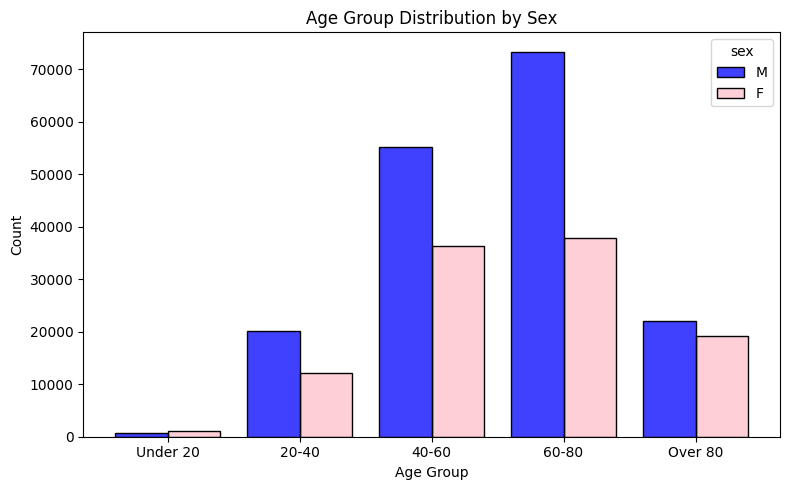

In [265]:
import seaborn as sns
import matplotlib.pyplot as plt

df_slices['age_group'] = pd.Categorical(df_slices['age_group'], categories=['Under 20', '20-40', '40-60', '60-80', 'Over 80'], ordered=True)
df_slices['sex'] = df_slices['sex'].astype(str)
custom_palette = {
    'M': 'blue',
    'F': 'pink'
}
# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(data=df_slices, x='age_group', hue='sex', multiple='dodge', shrink=0.8, palette=custom_palette, ax=ax)
ax.set_title("Age Group Distribution by Sex")
ax.set_xlabel("Age Group")
ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [266]:
df_slices[['sex','age_group','label']].value_counts(normalize=False)

sex  age_group  label
M    60-80      1        72298
     40-60      1        51241
F    60-80      1        37060
     40-60      1        32471
M    Over 80    1        22129
F    Over 80    1        19075
M    20-40      1        13701
F    20-40      1         7653
M    20-40      0         6448
F    20-40      0         4539
M    40-60      0         4021
F    40-60      0         3936
M    60-80      0         1089
F    60-80      0          835
     Under 20   1          580
M    Under 20   1          561
F    Under 20   0          463
M    Under 20   0          170
F    Over 80    0          142
Name: count, dtype: int64

In [267]:
df_slices['label'].value_counts(normalize=True)

label
1    0.922263
0    0.077737
Name: proportion, dtype: float64

In [268]:
# Step 1: Create unique patient-level DataFrame
df_patients = df_slices.drop_duplicates(subset="patient_id")[["patient_id", "sex", "age_group", "label"]].copy()
df_patients["use"] = True

# Step 2: Define group-wise drop fractions
groups_to_reduce = [
    {"sex": "M", "age_group": "60-80", "label": 1, "drop_fraction": 0.60},
    {"sex": "F", "age_group": "60-80", "label": 1, "drop_fraction": 0.50},
    {"sex": "M", "age_group": "40-60", "label": 1, "drop_fraction": 0.55},
    {"sex": "F", "age_group": "40-60", "label": 1, "drop_fraction": 0.50},
    {"sex": "M", "age_group": "Over 80", "label": 1, "drop_fraction": 0.30},
    {"sex": "F", "age_group": "Over 80", "label": 1, "drop_fraction": 0.30},
    {"sex": "M", "age_group": "20-40", "label": 1, "drop_fraction": 0.30},
    {"sex": "F", "age_group": "20-40", "label": 1, "drop_fraction": 0.30},
]

# Step 3: Downsample patients from large groups
for group in groups_to_reduce:
    mask = (
        (df_patients["sex"] == group["sex"]) &
        (df_patients["age_group"] == group["age_group"]) &
        (df_patients["label"] == group["label"])
    )
    to_drop = df_patients[mask].sample(frac=group["drop_fraction"], random_state=42).index
    df_patients.loc[to_drop, "use"] = False

# Step 4: Merge `use` flag back to slice-level DataFrame
df_filtered = df_slices.merge(df_patients[["patient_id", "use"]], on="patient_id", how="left")
# Step 5: Filter final dataset
df_filtered = df_filtered[df_filtered["use"] == True]

# Step 6: Show new class distribution
print("Label distribution after filtering:")
print(df_filtered["label"].value_counts(normalize=True))

print("\nDetailed distribution:")
print(df_filtered[['sex','age_group','label']].value_counts())


Label distribution after filtering:
label
1    0.861359
0    0.138641
Name: proportion, dtype: float64

Detailed distribution:
sex  age_group  label
M    60-80      1        29410
     40-60      1        23508
F    60-80      1        18678
     40-60      1        16869
M    Over 80    1        16531
F    Over 80    1        12923
M    20-40      1         9778
                0         6448
F    20-40      1         5627
                0         4539
M    40-60      0         4021
F    40-60      0         3936
M    60-80      0         1089
F    60-80      0          835
     Under 20   1          580
M    Under 20   1          561
F    Under 20   0          463
M    Under 20   0          170
F    Over 80    0          142
Name: count, dtype: int64


In [269]:
print(len(df_filtered[df_filtered['use']==True]))
print(df_filtered['patient_id'].nunique())

156108
1638


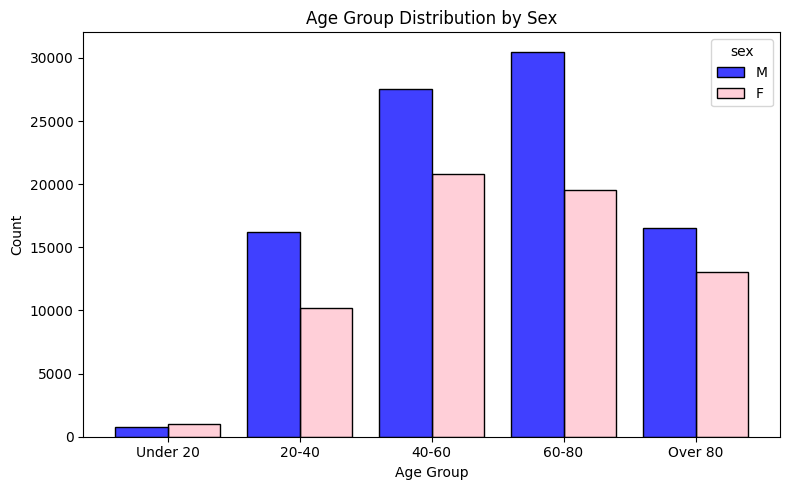

In [270]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(data=df_filtered, x='age_group', hue='sex', multiple='dodge', shrink=0.8, palette=custom_palette, ax=ax)
ax.set_title("Age Group Distribution by Sex")
ax.set_xlabel("Age Group")
ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [271]:
from sklearn.model_selection import train_test_split

def is_minority(row):
    return row['age_group'] in ['Under 20', '20-40', 'Over 80']

# Custom function to apply per patient
def extract_patient_info(patient_df):
    # Get mode age_group with fallback
    age_group_mode = patient_df['age_group'].mode()
    age_group_final = age_group_mode.iloc[0] if len(age_group_mode) == 1 else patient_df.iloc[0]['age_group']
    
    # Get mode gender with fallback
    sex_mode = patient_df['sex'].mode()
    sex_final = sex_mode.iloc[0] if len(sex_mode) == 1 else patient_df.iloc[0]['sex']

    # Get mode diagnosis with fallback
    diagnosis_mode = patient_df['label'].mode()
    diagnosis_final = diagnosis_mode.iloc[0] if len(diagnosis_mode) == 1 else patient_df.iloc[0]['label']
    
    return pd.Series({
        'sex': sex_final,
        'diagnosis': diagnosis_final,
        'age_group': age_group_final
    })


# Get unique patients with their age/gender info, apply this function per patient on the age_group
patient_info = df_filtered.groupby('patient_id').apply(extract_patient_info).reset_index()
patient_info['is_minority'] = patient_info.apply(is_minority, axis=1)

# Step 1: Split minority patients → Ground Truth (80%) and remaining (20%)
minority_patients = patient_info[patient_info['is_minority']]
majority_patients = patient_info[~patient_info['is_minority']]
gt_patients, minority_remain = train_test_split(minority_patients,
    train_size=0.44, test_size=0.56,
    stratify=minority_patients[['sex', 'age_group']],
    random_state=42
)

# Step 2: Combine remaining minority + majority → Remaining 84% of patients
remaining_patients = pd.concat([minority_remain, majority_patients])

# Step 3: Split remaining into test (60%), train (30%), val (10%)
temp_train_val, test_patients= train_test_split(remaining_patients,
    train_size=0.55, test_size=0.45,
    stratify=remaining_patients[['sex', 'age_group']],
    random_state=42
)
train_patients, val_patients = train_test_split(temp_train_val,
    test_size=0.25,  # 0.25 of 40% = 10%
    stratify=temp_train_val[['sex', 'age_group']],
    random_state=42
)

# Step 4: Assign split labels
def assign_split(df, split_name):
    df = df[['patient_id']].copy()
    df['split'] = split_name
    return df

split_assignments = pd.concat([
    assign_split(gt_patients, 'ground_truth'),
    assign_split(test_patients, 'test'),
    assign_split(train_patients, 'train'),
    assign_split(val_patients, 'val')
])

# Step 5: Merge back
df_split = df_filtered.merge(split_assignments, on='patient_id', how='left')
df_split

/tmp/ipykernel_31386/1526126153.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_info = df_filtered.groupby('patient_id').apply(extract_patient_info).reset_index()


,fname,image_path,patient_id,series_num,age,age_group,sex,finding,label,use,split
0,NCP_1002_2561_0020.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
1,NCP_1002_2561_0021.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
2,NCP_1002_2561_0022.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
3,NCP_1002_2561_0023.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
4,NCP_1002_2561_0024.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
...,...,...,...,...,...,...,...,...,...,...,...
156103,COVIDCTMD-normal076-IM0167.png,/home/coder/project/covidxct/3A_images/COVIDCT...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0,True,ground_truth
156104,COVIDCTMD-normal076-IM0168.png,/home/coder/project/covidxct/3A_images/COVIDCT...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0,True,ground_truth
156105,COVIDCTMD-normal076-IM0169.png,/home/coder/project/covidxct/3A_images/COVIDCT...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0,True,ground_truth
156106,COVIDCTMD-normal076-IM0170.png,/home/coder/project/covidxct/3A_images/COVIDCT...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0,True,ground_truth


In [ ]:
df_split['split'].isna().sum()

np.int64(0)

In [273]:
df_split['split'].value_counts(normalize=True)

split
test            0.375189
train           0.348112
ground_truth    0.160376
val             0.116323
Name: proportion, dtype: float64

In [253]:
df_split['finding'].value_counts(normalize=True)

finding
COVID-19    0.861359
Normal      0.138641
Name: proportion, dtype: float64

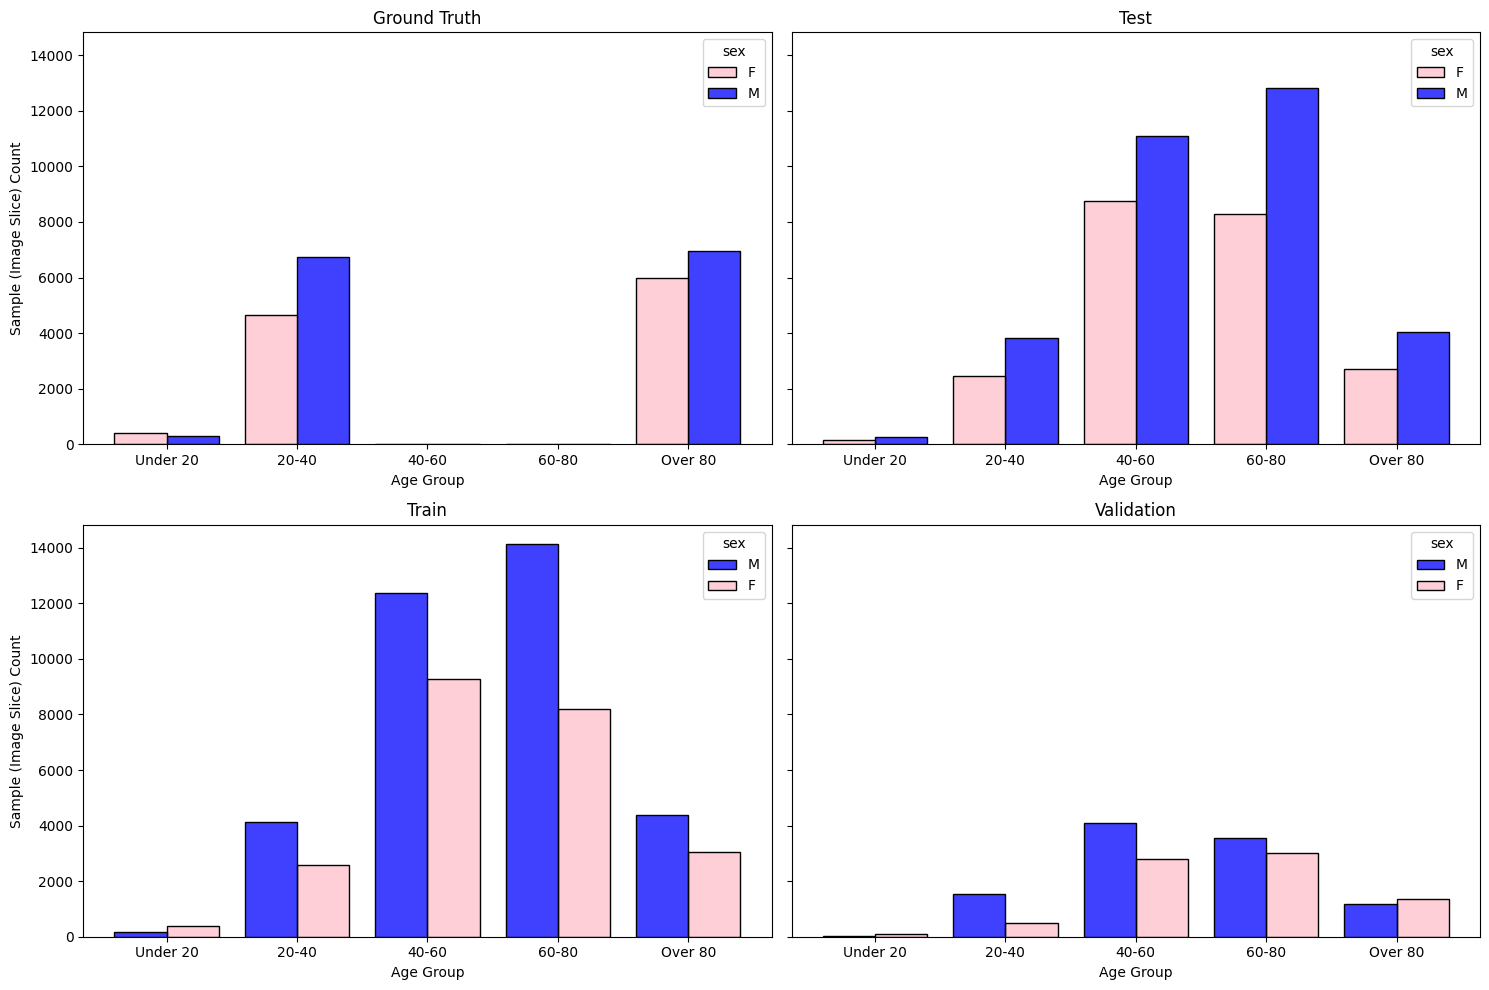

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Patient_sex and age_group are categorical for consistent ordering
df_split['age_group'] = pd.Categorical(df_split['age_group'], categories=['Under 20', '20-40', '40-60', '60-80', 'Over 80'], ordered=True)
df_split['sex'] = df_split['sex'].astype(str)

# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
# Flatten axes array for easy indexing
axes = axes.flatten()
# Define custom color palette
custom_palette = {
    'M': 'blue',
    'F': 'pink'
}

# Define splits and titles
splits = ['ground_truth', 'train', 'test', 'val']
titles = ['Ground Truth', 'Test', 'Train', 'Validation']

# Plot histograms
for i, split in enumerate(splits):
    ax = axes[i]
    sns.histplot(
        data=df_split[df_split['split'] == split],
        x='age_group',
        hue='sex',
        multiple='dodge',
        shrink=0.8,
        palette=custom_palette,
        ax=ax
    )
    ax.set_title(titles[i])
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Sample (Image Slice) Count')
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [256]:
df_split[df_split['split']=='ground_truth']['label'].value_counts(normalize=True)

label
1    0.774165
0    0.225835
Name: proportion, dtype: float64

In [257]:
df_split[df_split['split']=='ground_truth'][['sex', 'age_group', 'label']].value_counts()

sex  age_group  label
M    Over 80    1        6958
F    Over 80    1        5986
M    20-40      1        3503
                0        3242
F    20-40      1        2461
                0        2191
M    Under 20   1         260
F    Under 20   1         214
                0         201
M    Under 20   0          20
Name: count, dtype: int64

In [258]:
df_split[df_split['split']=='test']['label'].value_counts(normalize=True)

label
1    0.888253
0    0.111747
Name: proportion, dtype: float64

In [259]:
df_split[df_split['split']=='test'][['sex', 'age_group', 'label']].value_counts()

sex  age_group  label
M    60-80      1        13494
     40-60      1        10620
F    60-80      1         8023
     40-60      1         7819
M    Over 80    1         4366
F    Over 80    1         2901
M    20-40      1         2746
F    20-40      1         1764
M    40-60      0         1743
F    40-60      0         1439
M    20-40      0         1368
F    20-40      0          807
M    60-80      0          624
F    Under 20   1          191
                0          178
     60-80      0          176
     Over 80    0          142
M    Under 20   1          101
                0           68
Name: count, dtype: int64

In [260]:
df_split[df_split['split']=='train']['label'].value_counts(normalize=True)

label
1    0.868484
0    0.131516
Name: proportion, dtype: float64

In [261]:
df_split[df_split['split']=='train'][['sex', 'age_group', 'label']].value_counts()

sex  age_group  label
M    60-80      1        12371
     40-60      1         9268
F    60-80      1         7661
     40-60      1         7081
M    Over 80    1         4024
F    Over 80    1         2692
M    20-40      1         2556
     40-60      0         1819
F    40-60      0         1669
     20-40      1         1268
M    20-40      0         1267
F    20-40      0         1190
     60-80      0          629
M    60-80      0          440
     Under 20   1          200
F    Under 20   0           84
                1           75
M    Under 20   0           49
Name: count, dtype: int64

In [262]:
df_split[df_split['split']=='val']['label'].value_counts(normalize=True)

label
1    0.873506
0    0.126494
Name: proportion, dtype: float64

In [263]:
df_split[df_split['split']=='val'][['sex', 'age_group', 'label']].value_counts()

sex  age_group  label
M    40-60      1        3620
     60-80      1        3545
F    60-80      1        2994
     40-60      1        1969
     Over 80    1        1344
M    Over 80    1        1183
     20-40      1         973
F    40-60      0         828
M    20-40      0         571
     40-60      0         459
F    20-40      0         351
                1         134
     Under 20   1         100
M    Under 20   0          33
F    60-80      0          30
M    60-80      0          25
Name: count, dtype: int64

# Verify splits

In [274]:
df_split = pd.read_csv('/home/coder/project/covidxct/proc_slices_metadata.csv')
df_split

,fname,image_path,patient_id,series_num,age,age_group,sex,finding,label,use,split
0,NCP_1002_2561_0020.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
1,NCP_1002_2561_0021.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
2,NCP_1002_2561_0022.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
3,NCP_1002_2561_0023.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
4,NCP_1002_2561_0024.png,/home/coder/project/covidxct/3A_images/NCP_100...,NCP_1002,2561.0,39.0,20-40,M,COVID-19,1,True,test
...,...,...,...,...,...,...,...,...,...,...,...
156103,COVIDCTMD-normal076-IM0167.png,/home/coder/project/covidxct/3A_images/COVIDCT...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0,True,ground_truth
156104,COVIDCTMD-normal076-IM0168.png,/home/coder/project/covidxct/3A_images/COVIDCT...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0,True,ground_truth
156105,COVIDCTMD-normal076-IM0169.png,/home/coder/project/covidxct/3A_images/COVIDCT...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0,True,ground_truth
156106,COVIDCTMD-normal076-IM0170.png,/home/coder/project/covidxct/3A_images/COVIDCT...,COVIDCTMD-normal076,NaN,30.0,20-40,M,Normal,0,True,ground_truth


In [275]:
df_split[df_split['split']=='ground_truth']['label'].value_counts(normalize=True)

label
1    0.774165
0    0.225835
Name: proportion, dtype: float64

In [276]:
df_split[df_split['split']=='ground_truth'][['sex', 'age_group', 'label']].value_counts()

sex  age_group  label
M    Over 80    1        6958
F    Over 80    1        5986
M    20-40      1        3503
                0        3242
F    20-40      1        2461
                0        2191
M    Under 20   1         260
F    Under 20   1         214
                0         201
M    Under 20   0          20
Name: count, dtype: int64